In [2]:
import pickle, glob

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import StrMethodFormatter, NullFormatter, ScalarFormatter
from matplotlib.transforms import ScaledTranslation

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

colors_2_ = ['#126463', '#2CB7B5', '#CA8250']
#colors_3_ = ['#1F390D', '#756A00', '#D8A581', '#92918B']
colors_3_ = ['#1F390D', '#756A00', '#D8A581', '#92918B', '#2CB7B5']

path_to_mdls   = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'
path_to_prc    = r'/Users/Guille/Desktop/caiso_power/data/processed/'
path_to_images = r'/Users/Guille/Desktop/caiso_power/images/'

# Load Independent and Joint Energy Forecast Model Selection - Ignorance Score

In [3]:
ts_is_scores_ = pd.read_csv('independent_resources_IS.csv', index_col = 0)
ts_ms_scores_ = pd.read_csv('multiple_resources_IS.csv', index_col = 0)
ts_ms_scores_['dense_method'] = 'MRGPR'
print(ts_is_scores_)
print(ts_ms_scores_)
ts_scores_    = pd.concat([ts_is_scores_, ts_ms_scores_], axis = 0)
ts_scores_.loc[ts_scores_['dense_method'] == 'MTGPR', 'dense_method'] = 'MNGPR'
print(ts_scores_)

   sparse_method dense_method score         IS60         IS80         IS90  \
0            OMP          BLR    ES  2806.009305  3659.852021  4460.779184   
1            OMP          BLR    IS  2765.402588  3567.361581  4322.637806   
2            OMP          BLR  LogS  2757.784031  3569.620514  4329.771191   
3            OMP          BLR  RMSE  2774.665305  3610.480214  4396.851303   
4            OMP          BLR    VS  2781.580452  3590.705984  4351.338963   
..           ...          ...   ...          ...          ...          ...   
75         lasso          RVM    ES  3283.163049  4659.827909  6469.821226   
76         lasso          RVM    IS  3137.656867  3985.981538  4806.232770   
77         lasso          RVM  LogS  2975.032968  3927.192835  4902.990480   
78         lasso          RVM  RMSE  2975.136554  3935.421642  4915.875748   
79         lasso          RVM    VS  3283.163049  4659.827909  6469.821226   

           IS95         IS975            IS  
0   5245.414873  

# Load Baselines Models

In [4]:
def _load_model_data(model_name, path):
    
    _model        = pd.read_pickle(path + model_name)
    meta_         = _model['targets_meta']
    meta_['date'] = pd.to_datetime(meta_[["year", "month", "day"]])
    meta_['date'] = meta_['date'].dt.strftime('%m/%d/%Y')
    
    return _model, meta_

In [5]:
l_baselines_file_name = 'load-1-2-3_baselines.pkl'
s_baselines_file_name = 'solar-0-1-2_baselines.pkl'
w_baselines_file_name = 'wind-0-1_baselines.pkl'

_l_baselines = pd.read_pickle(path_to_prc + l_baselines_file_name)
_s_baselines = pd.read_pickle(path_to_prc + s_baselines_file_name)
_w_baselines = pd.read_pickle(path_to_prc + w_baselines_file_name)

# Imbalance Market

## Independenet Energy Forecast Simulations

In [6]:
def _is_reserve_level(models_, baselines_, zones_, caiso_rs_level, i_sel_sample):

    def __get_forecast(_model, _baselines, zones_, i_sel_sample):

        y_       = []
        mu_      = []
        s2_      = []
        y_caiso_ = []
        for i_zone in zones_:
            y_.append(_model['targets'][i_sel_sample, i_zone, :])
            mu_.append(_model['mean'][i_sel_sample, i_zone, :])
            s2_.append(np.sqrt(_model['variance'][i_sel_sample, i_zone, :]))
            y_caiso_.append(_baselines['caiso'][i_sel_sample, i_zone, :])

        return y_, mu_, s2_, y_caiso_

    l_, l_mu_, l_s2_, l_caiso_ = __get_forecast(models_[0], baselines_[0], zones_[0], i_sel_sample)
    s_, s_mu_, s_s2_, s_caiso_ = __get_forecast(models_[1], baselines_[1], zones_[1], i_sel_sample)
    w_, w_mu_, w_s2_, w_caiso_ = __get_forecast(models_[2], baselines_[2], zones_[2], i_sel_sample)

    net_         = np.zeros((24,))
    net_ml_      = np.zeros((24,))
    net_caiso_   = np.zeros((24,))
    ml_reserves_ = np.zeros((24,))

    for i_load in range(len(l_)):
        net_         += l_[i_load]
        net_ml_      += l_mu_[i_load]
        net_caiso_   += l_caiso_[i_load]
        ml_reserves_ += l_s2_[i_load]

    l_caiso = net_caiso_.copy()

    for i_solar in range(len(s_)):
        net_         -= s_[i_solar]
        net_ml_      -= s_mu_[i_solar]
        net_caiso_   -= s_caiso_[i_solar]
        ml_reserves_ += s_s2_[i_solar]

    for i_wind in range(len(w_)):
        net_         -= w_[i_wind]
        net_ml_      -= w_mu_[i_wind]
        net_caiso_   -= w_caiso_[i_wind]
        ml_reserves_ += w_s2_[i_wind]

    caiso_reserves_ = l_caiso*caiso_rs_level

    E_caiso = 2.*caiso_reserves_.sum()
    z       = caiso_reserves_.sum()/ml_reserves_.sum()
    E_ml    = 2.*z*ml_reserves_.sum()
    
    return net_, net_caiso_, net_ml_, caiso_reserves_, z*ml_reserves_


def _is_simulate_imbalance_market(models_, baselines_, caiso_rs_level, i_zone, N_samples):
    
    l_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
    s_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
    w_zones_idx_ = [[0], [1], [], [0, 1]][i_zone]

    ml_im_buy_     = np.zeros((24,))
    ml_im_sell_    = np.zeros((24,))
    caiso_im_buy_  = np.zeros((24,))
    caiso_im_sell_ = np.zeros((24,))

    for i_sample in range(N_samples):
        (net_, 
         net_caiso_, 
         net_ml_, 
         rs_caiso_, 
         rs_ml_) = _is_reserve_level(models_        = models_, 
                                     baselines_     = baselines_, 
                                     zones_         = [l_zones_idx_, s_zones_idx_, w_zones_idx_], 
                                     caiso_rs_level = caiso_rs_level, 
                                     i_sel_sample   = i_sample)
        

        ml_im_sell_p_    = np.zeros((24,))

    
        idx_                  = net_ > (net_caiso_ + rs_caiso_)
        caiso_im_buy_[idx_]  -= net_[idx_] - (net_caiso_[idx_] + rs_caiso_[idx_])
        idx_                  = net_ < (net_caiso_ - rs_caiso_)
        caiso_im_sell_[idx_] -= net_[idx_] - (net_caiso_[idx_] - rs_caiso_[idx_])

        idx_               = net_ > (net_ml_ + rs_ml_)
        ml_im_buy_[idx_]  -= net_[idx_] - (net_ml_[idx_] + rs_ml_[idx_])
        idx_               = net_ < (net_ml_ - rs_ml_)
        ml_im_sell_[idx_] -= net_[idx_] - (net_ml_[idx_] - rs_ml_[idx_])

        
    caiso_im_buy_  /= N_samples
    caiso_im_sell_ /= N_samples

    ml_im_buy_  /= N_samples
    ml_im_sell_ /= N_samples
    
    return [caiso_im_buy_, caiso_im_sell_], [ml_im_buy_, ml_im_sell_]

In [7]:
# path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

# l_ml_model_name = 'load-OMP-MTGPR-LogS.pkl'
# s_ml_model_name = 'solar-OMP-MTGPR-LogS.pkl'
# w_ml_model_name = 'wind-OMP-MTGPR-LogS.pkl'
# #ml_model_name = 'wind-elastic_net-GPR-LogS.pkl'

# _l_model, l_meta_ = _load_model_data(l_ml_model_name, path_to_mdls)
# _s_model, s_meta_ = _load_model_data(s_ml_model_name, path_to_mdls)
# _w_model, w_meta_ = _load_model_data(w_ml_model_name, path_to_mdls)

# i_zone = 3
# zones_ = ['NP15', 'ZP26', 'SP15', 'CAISO']
# zone   = zones_[i_zone]

# models_resource_ = [_l_model, _s_model, _w_model]
# baselines_       = [_l_baselines, _s_baselines, _w_baselines]

# caiso_im_, ml_im_ = _simulate_imbalance_market(models_        = models_resource_, 
#                                                baselines_     = baselines_, 
#                                                caiso_rs_level = 0.12, 
#                                                i_zone         = i_zone,
#                                                N_samples      = 243)
# print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum())
# print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[1].sum() + caiso_im_[0].sum())

In [8]:
path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

imports_ = []
for sparse_method in ['lasso', 'OMP', 'elastic_net', 'group_lasso']:
    for dense_method in ['BLR', 'RVM', 'GPR', 'MTGPR']:
        for score in ['ES', 'VS', 'LogS', 'IS']:

            l_ml_model_name = 'load-{}-{}-{}.pkl'.format(sparse_method, dense_method, score)
            s_ml_model_name = 'solar-{}-{}-{}.pkl'.format(sparse_method, dense_method, score)
            w_ml_model_name = 'wind-{}-{}-{}.pkl'.format(sparse_method, dense_method, score)

            _l_model, l_meta_ = _load_model_data(l_ml_model_name, path_to_mdls)
            _s_model, s_meta_ = _load_model_data(s_ml_model_name, path_to_mdls)
            _w_model, w_meta_ = _load_model_data(w_ml_model_name, path_to_mdls)

            i_zone = 3
            zones_ = ['NP15', 'ZP26', 'SP15', 'CAISO']
            zone   = zones_[i_zone]

            models_resource_ = [_l_model, _s_model, _w_model]
            baselines_       = [_l_baselines, _s_baselines, _w_baselines]

            caiso_im_, ml_im_ = _is_simulate_imbalance_market(models_        = models_resource_, 
                                                           baselines_     = baselines_, 
                                                           caiso_rs_level = 0.12, 
                                                           i_zone         = i_zone,
                                                           N_samples      = 243)
            
            imports_.append([sparse_method, dense_method, score, ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum()])
            # print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum())
            # print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[1].sum() + caiso_im_[0].sum())
            
imports_1_ = pd.DataFrame(imports_, columns = ['sparse_method', 'dense_method', 'score', 'imports', 'exports', 'net'])   
print(imports_1_.loc[imports_1_['sparse_method'] == 'OMP'])

   sparse_method dense_method score      imports     exports          net
16           OMP          BLR    ES  -326.763921  123.535830  -203.228091
17           OMP          BLR    VS  -409.555736   89.796893  -319.758843
18           OMP          BLR  LogS  -381.112954   77.495365  -303.617589
19           OMP          BLR    IS  -402.028018   86.620431  -315.407587
20           OMP          RVM    ES  -498.256078  247.546667  -250.709411
21           OMP          RVM    VS  -470.404789  246.662293  -223.742496
22           OMP          RVM  LogS  -469.722864  184.126668  -285.596196
23           OMP          RVM    IS  -327.870500  211.623487  -116.247013
24           OMP          GPR    ES  -316.647619  171.765750  -144.881869
25           OMP          GPR    VS  -894.144279  436.761349  -457.382930
26           OMP          GPR  LogS  -362.243830  124.248979  -237.994851
27           OMP          GPR    IS  -353.906203  124.419878  -229.486324
28           OMP        MTGPR    ES  -

## Joint Energy Forecast Simulations

In [9]:
def _ms_reserve_level(models_, baselines_, zones_, caiso_rs_level, i_sel_sample):

    def __get_baseline_forecast(_baselines, zones_, i_sel_sample):
        y_caiso_ = []
        for i_zone in zones_:
            y_caiso_.append(_baselines['caiso'][i_sel_sample, i_zone, :])
        return y_caiso_
    
    def __get_forecast(models_, i_zone, i_sample):
        
        y_  = []
        mu_ = []
        s2_ = []
        
        for _model in models_:
            if (_model['targets'].shape[1] == 2) and ( i_zone == 2):
                pass
            else:
                y_.append(_model['targets'][i_sample, i_zone, :])
                mu_.append(_model['mean'][i_sample, i_zone, :])
                s2_.append(np.sqrt(_model['variance'][i_sample, i_zone, :]))

        return y_, mu_, s2_

    l_caiso_ = __get_baseline_forecast(baselines_[0], zones_[0], i_sel_sample)
    s_caiso_ = __get_baseline_forecast(baselines_[1], zones_[1], i_sel_sample)
    w_caiso_ = __get_baseline_forecast(baselines_[2], zones_[2], i_sel_sample)
    
    l_, l_mu_, l_s2_ = __get_forecast(models_, 0, i_sel_sample)
    s_, s_mu_, s_s2_ = __get_forecast(models_, 1, i_sel_sample)
    w_, w_mu_, w_s2_ = __get_forecast(models_, 2, i_sel_sample)

    net_         = np.zeros((24,))
    net_ml_      = np.zeros((24,))
    net_caiso_   = np.zeros((24,))
    ml_reserves_ = np.zeros((24,))

    for i_load in range(len(l_caiso_)):
        net_         += l_[i_load]
        net_ml_      += l_mu_[i_load]
        net_caiso_   += l_caiso_[i_load]
        ml_reserves_ += l_s2_[i_load]

    l_caiso = net_caiso_.copy()

    for i_solar in range(len(s_caiso_)):
        net_         -= s_[i_solar]
        net_ml_      -= s_mu_[i_solar]
        net_caiso_   -= s_caiso_[i_solar]
        ml_reserves_ += s_s2_[i_solar]

    for i_wind in range(len(w_caiso_)):
        net_         -= w_[i_wind]
        net_ml_      -= w_mu_[i_wind]
        net_caiso_   -= w_caiso_[i_wind]
        ml_reserves_ += w_s2_[i_wind]

    caiso_reserves_ = l_caiso*caiso_rs_level

    E_caiso = 2.*caiso_reserves_.sum()
    z       = caiso_reserves_.sum()/ml_reserves_.sum()
    E_ml    = 2.*z*ml_reserves_.sum()
    
    return net_, net_caiso_, net_ml_, caiso_reserves_, z*ml_reserves_


def _ms_simulate_imbalance_market(models_, baselines_, caiso_rs_level, i_zone, N_samples):
    
    l_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
    s_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
    w_zones_idx_ = [[0], [1], [], [0, 1]][i_zone]

    ml_im_buy_     = np.zeros((24,))
    ml_im_sell_    = np.zeros((24,))
    caiso_im_buy_  = np.zeros((24,))
    caiso_im_sell_ = np.zeros((24,))

    for i_sample in range(N_samples):
        (net_, 
         net_caiso_, 
         net_ml_, 
         rs_caiso_, 
         rs_ml_) = _ms_reserve_level(models_        = models_, 
                                     baselines_     = baselines_, 
                                     zones_         = [l_zones_idx_, s_zones_idx_, w_zones_idx_], 
                                     caiso_rs_level = caiso_rs_level, 
                                     i_sel_sample   = i_sample)
        

        ml_im_sell_p_    = np.zeros((24,))

    
        idx_                  = net_ > (net_caiso_ + rs_caiso_)
        caiso_im_buy_[idx_]  -= net_[idx_] - (net_caiso_[idx_] + rs_caiso_[idx_])
        idx_                  = net_ < (net_caiso_ - rs_caiso_)
        caiso_im_sell_[idx_] -= net_[idx_] - (net_caiso_[idx_] - rs_caiso_[idx_])

        idx_               = net_ > (net_ml_ + rs_ml_)
        ml_im_buy_[idx_]  -= net_[idx_] - (net_ml_[idx_] + rs_ml_[idx_])
        idx_               = net_ < (net_ml_ - rs_ml_)
        ml_im_sell_[idx_] -= net_[idx_] - (net_ml_[idx_] - rs_ml_[idx_])

        
    caiso_im_buy_  /= N_samples
    caiso_im_sell_ /= N_samples

    ml_im_buy_  /= N_samples
    ml_im_sell_ /= N_samples
    
    return [caiso_im_buy_, caiso_im_sell_], [ml_im_buy_, ml_im_sell_]

In [10]:
path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-4/'

imports_ = []
for sparse_method in ['lasso', 'OMP', 'elastic_net', 'group_lasso']:
    for score in ['ES', 'VS', 'LogS', 'IS']:
        NP15_model_name = 'NP15-{}-MTGPR-{}.pkl'.format(sparse_method, score)
        SP15_model_name = 'SP15-{}-MTGPR-{}.pkl'.format(sparse_method, score)
        ZP26_model_name = 'ZP26-{}-MTGPR-{}.pkl'.format(sparse_method, score)

        _model_1, meta_1_ = _load_model_data(NP15_model_name, path_to_mdls)
        _model_2, meta_2_ = _load_model_data(SP15_model_name, path_to_mdls)
        _model_3, meta_3_ = _load_model_data(ZP26_model_name, path_to_mdls)

        i_zone = 3
        zones_ = ['NP15', 'ZP26', 'SP15', 'CAISO']
        zone   = zones_[i_zone]

        models_zone_ = [_model_1, _model_2, _model_3]
        baselines_   = [_l_baselines, _s_baselines, _w_baselines]

        caiso_im_, ml_im_ = _ms_simulate_imbalance_market(models_        = models_zone_, 
                                                          baselines_     = baselines_, 
                                                          caiso_rs_level = 0.12, 
                                                          i_zone         = i_zone,
                                                          N_samples      = 243)

        imports_.append([sparse_method, 'multi-resource', score, ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum()])

imports_2_ = pd.DataFrame(imports_, columns = ['sparse_method', 'dense_method', 'score', 'imports', 'exports', 'net'])   
print(imports_2_)

   sparse_method    dense_method score      imports      exports         net
0          lasso  multi-resource    ES  -132.469847   181.091449   48.621602
1          lasso  multi-resource    VS  -928.325835   459.165728 -469.160107
2          lasso  multi-resource  LogS -1039.667776   640.374649 -399.293127
3          lasso  multi-resource    IS  -178.416347   163.420449  -14.995898
4            OMP  multi-resource    ES   -69.532491   344.365641  274.833150
5            OMP  multi-resource    VS -1015.832280   438.286610 -577.545670
6            OMP  multi-resource  LogS -1401.104887   792.882050 -608.222837
7            OMP  multi-resource    IS   -76.484912   267.304793  190.819881
8    elastic_net  multi-resource    ES  -118.078429   218.875486  100.797057
9    elastic_net  multi-resource    VS  -886.346792   461.094152 -425.252640
10   elastic_net  multi-resource  LogS -1021.937754   609.383554 -412.554200
11   elastic_net  multi-resource    IS  -141.028237   218.560585   77.532348

In [11]:
imports_ = pd.concat([imports_1_, imports_2_], axis = 0).reset_index(drop = True)
print(imports_.shape)

(80, 6)


# Operational Reserves Allocation

In [66]:
zones_ = ['NP15', 'ZP26', 'SP15', 'CAISO']

i_zone = 3
zone   = zones_[i_zone]

l_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
s_zones_idx_ = [[0], [1], [2], [0, 1, 2]][i_zone]
w_zones_idx_ = [[0], [1], [], [0, 1]][i_zone]

baselines_ = [_l_baselines, _s_baselines, _w_baselines]

## Independent Energy Forecast

In [67]:
path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

values_ = []

# l_ml_model_name = 'load-elastic_net-BLR-LogS.pkl'
# s_ml_model_name = 'solar-elastic_net-BLR-LogS.pkl'
# w_ml_model_name = 'wind-elastic_net-BLR-LogS.pkl'

l_ml_model_name = 'load-elastic_net-BLR-IS.pkl'
s_ml_model_name = 'solar-elastic_net-BLR-IS.pkl'
w_ml_model_name = 'wind-elastic_net-BLR-IS.pkl'

_l_model, l_meta_ = _load_model_data(l_ml_model_name, path_to_mdls)
_s_model, s_meta_ = _load_model_data(s_ml_model_name, path_to_mdls)
_w_model, w_meta_ = _load_model_data(w_ml_model_name, path_to_mdls)

caiso_im_, ml_im_ = _is_simulate_imbalance_market(models_        = [_l_model, _s_model, _w_model], 
                                                  baselines_     = baselines_, 
                                                  caiso_rs_level = 0.12, 
                                                  i_zone         = i_zone,
                                                  N_samples      = 243)

print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum())
print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[1].sum() + caiso_im_[0].sum())

values_.append(['Demand, Solar & Wind (EE+BLR)', 
                -ml_im_[0].sum(), -ml_im_[1].sum(), -ml_im_[1].sum() - ml_im_[0].sum()])

-297.41018084468294 107.04322302020171 -190.36695782448123
-4903.2979681069955 0.0 -4903.2979681069955


In [68]:
path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-4/'

# NP15_model_name = 'NP15-lasso-MTGPR-ES.pkl'
# SP15_model_name = 'SP15-lasso-MTGPR-ES.pkl'
# ZP26_model_name = 'ZP26-lasso-MTGPR-LogS.pkl'

NP15_model_name = 'NP15-OMP-MTGPR-IS.pkl'
SP15_model_name = 'SP15-OMP-MTGPR-IS.pkl'
ZP26_model_name = 'ZP26-OMP-MTGPR-IS.pkl'

_model_1, meta_1_ = _load_model_data(NP15_model_name, path_to_mdls)
_model_2, meta_2_ = _load_model_data(SP15_model_name, path_to_mdls)
_model_3, meta_3_ = _load_model_data(ZP26_model_name, path_to_mdls)

caiso_im_, ml_im_ = _ms_simulate_imbalance_market(models_        = [_model_1, _model_2, _model_3], 
                                                  baselines_     = baselines_, 
                                                  caiso_rs_level = 0.12, 
                                                  i_zone         = i_zone,
                                                  N_samples      = 243)

print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum())
print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[1].sum() + caiso_im_[0].sum())

values_.append(['NP15, SP15 & ZP26 (OMP+NLGPR)', -ml_im_[0].sum(), -ml_im_[1].sum(), -ml_im_[1].sum() - ml_im_[0].sum()])

-76.48491155960396 267.3047929710376 190.81988141143364
-4903.2979681069955 0.0 -4903.2979681069955


## Joint Energy Forecast

## Independent Energy Forecast - Ensemble

In [69]:
path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

# l_ml_model_name = 'load-lasso-BLR-LogS.pkl'
# s_ml_model_name = 'solar-elastic_net-BLR-LogS.pkl'
# w_ml_model_name = 'wind-elastic_net-GPR-LogS.pkl'

l_ml_model_name = 'load-elastic_net-BLR-IS.pkl'
s_ml_model_name = 'solar-elastic_net-BLR-IS.pkl'
w_ml_model_name = 'wind-elastic_net-GPR-IS.pkl'

_l_model, l_meta_ = _load_model_data(l_ml_model_name, path_to_mdls)
_s_model, s_meta_ = _load_model_data(s_ml_model_name, path_to_mdls)
_w_model, w_meta_ = _load_model_data(w_ml_model_name, path_to_mdls)

caiso_im_, ml_im_ = _is_simulate_imbalance_market(models_        = [_l_model, _s_model, _w_model], 
                                               baselines_     = baselines_, 
                                               caiso_rs_level = 0.12, 
                                               i_zone         = i_zone,
                                               N_samples      = 243)

print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum())
print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[1].sum() + caiso_im_[0].sum())

values_.append(['Demand (Lasso+BLR), Solar (EE+BLR) & Wind (EE+GPR)', 
                -ml_im_[0].sum(), -ml_im_[1].sum(), -ml_im_[1].sum() - ml_im_[0].sum()])

-227.24111067620754 120.46408902981042 -106.77702164639712
-4903.2979681069955 0.0 -4903.2979681069955


In [70]:
# path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

# l_ml_model_name = 'load-elastic_net-BLR-LogS.pkl'
# s_ml_model_name = 'solar-elastic_net-BLR-LogS.pkl'
# w_ml_model_name = 'wind-elastic_net-GPR-LogS.pkl'

# _l_model, l_meta_ = _load_model_data(l_ml_model_name, path_to_mdls)
# _s_model, s_meta_ = _load_model_data(s_ml_model_name, path_to_mdls)
# _w_model, w_meta_ = _load_model_data(w_ml_model_name, path_to_mdls)

# caiso_im_, ml_im_ = _is_simulate_imbalance_market(models_        = [_l_model, _s_model, _w_model], 
#                                                    baselines_     = baselines_, 
#                                                    caiso_rs_level = 0.12, 
#                                                    i_zone         = i_zone,
#                                                    N_samples      = 243)

# print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum())
# print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[1].sum() + caiso_im_[0].sum())

# values_.append(['Load (EE+BLR), Solar (EE+BLR) & Wind (EE+GPR)', 
#                 -ml_im_[0].sum(), -ml_im_[1].sum(), -ml_im_[1].sum() - ml_im_[0].sum()])

## Joint Energy Forecast - Ensemble

In [71]:
path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-2/'

# NP15_model_name = 'NP15-lasso-MTGPR-ES.pkl'
# SP15_model_name = 'SP15-OMP-MTGPR-ES.pkl'
# ZP26_model_name = 'ZP26-OMP-MTGPR-VS.pkl'

NP15_model_name = 'NP15-OMP-MTGPR-IS.pkl'
SP15_model_name = 'SP15-Lasso-MTGPR-IS.pkl'
ZP26_model_name = 'ZP26-Group_Lasso-MTGPR-IS.pkl'

_model_1, meta_1_ = _load_model_data(NP15_model_name, path_to_mdls)
_model_2, meta_2_ = _load_model_data(SP15_model_name, path_to_mdls)
_model_3, meta_3_ = _load_model_data(ZP26_model_name, path_to_mdls)

caiso_im_, ml_im_ = _ms_simulate_imbalance_market(models_        = [_model_1, _model_2, _model_3], 
                                                  baselines_     = baselines_, 
                                                  caiso_rs_level = 0.12, 
                                                  i_zone         = i_zone,
                                                  N_samples      = 243)

print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum())
print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[1].sum() + caiso_im_[0].sum())

values_.append(['NP15 (OMP+NLGPR), SP15 (Lasso+NLGPR) & ZP26 (GL+NLGPR)', 
                -ml_im_[0].sum(), -ml_im_[1].sum(), -ml_im_[1].sum() - ml_im_[0].sum()])

-155.9206060137819 179.92705281140184 24.00644679761993
-4903.2979681069955 0.0 -4903.2979681069955


In [72]:
df_ = pd.DataFrame(values_, columns = ['model', 'imports', 'curtailment', 'net'])
print(df_)

                                               model     imports  curtailment  \
0                      Demand, Solar & Wind (EE+BLR)  297.410181  -107.043223   
1                      NP15, SP15 & ZP26 (OMP+NLGPR)   76.484912  -267.304793   
2  Demand (Lasso+BLR), Solar (EE+BLR) & Wind (EE+...  227.241111  -120.464089   
3  NP15 (OMP+NLGPR), SP15 (Lasso+NLGPR) & ZP26 (G...  155.920606  -179.927053   

          net  
0  190.366958  
1 -190.819881  
2  106.777022  
3  -24.006447  


In [73]:
# path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-2/'

# NP15_model_name = 'NP15-lasso-MTGPR-ES.pkl'
# SP15_model_name = 'SP15-lasso-MTGPR-ES.pkl'
# ZP26_model_name = 'ZP26-elastic_net-MTGPR-LogS.pkl'

# _model_1, meta_1_ = _load_model_data(NP15_model_name, path_to_mdls)
# _model_2, meta_2_ = _load_model_data(SP15_model_name, path_to_mdls)
# _model_3, meta_3_ = _load_model_data(ZP26_model_name, path_to_mdls)

# caiso_im_, ml_im_ = _ms_simulate_imbalance_market(models_        = [_model_1, _model_2, _model_3], 
#                                                   baselines_     = baselines_, 
#                                                   caiso_rs_level = 0.12, 
#                                                   i_zone         = i_zone,
#                                                   N_samples      = 243)

# print(ml_im_[0].sum(), ml_im_[1].sum(), ml_im_[1].sum() + ml_im_[0].sum())
# print(caiso_im_[0].sum(), caiso_im_[1].sum(), caiso_im_[1].sum() + caiso_im_[0].sum())

# values_.append(['NP15 (Lasso+MS), SP15 (Lasso+MS) & ZP26 (EE+MS)', 
#                 -ml_im_[0].sum(), -ml_im_[1].sum(), -ml_im_[1].sum() - ml_im_[0].sum()])

# # values_.append(['CAISO', 
# #                 -caiso_im_[0].sum(), -caiso_im_[1].sum(), -caiso_im_[1].sum() - caiso_im_[0].sum()])

## Imbalance Market Simulation - Import and Curtailment

In [74]:
def _market(net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_):
    
    ml_im_buy_     = np.zeros((24,))
    ml_im_sell_    = np.zeros((24,))
    caiso_im_buy_  = np.zeros((24,))
    caiso_im_sell_ = np.zeros((24,))
    
    idx_                  = net_ > (net_caiso_ + rs_caiso_)
    caiso_im_buy_[idx_]  -= net_[idx_] - (net_caiso_[idx_] + rs_caiso_[idx_])
    idx_                  = net_ < (net_caiso_ - rs_caiso_)
    caiso_im_sell_[idx_] -= net_[idx_] - (net_caiso_[idx_] - rs_caiso_[idx_])

    idx_               = net_ > (net_ml_ + rs_ml_)
    ml_im_buy_[idx_]  -= net_[idx_] - (net_ml_[idx_] + rs_ml_[idx_])
    idx_               = net_ < (net_ml_ - rs_ml_)
    ml_im_sell_[idx_] -= net_[idx_] - (net_ml_[idx_] - rs_ml_[idx_])
    return caiso_im_buy_, caiso_im_sell_, ml_im_buy_, ml_im_sell_

In [75]:
for i_sample in range(243):

    net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_ = _is_reserve_level(models_        = [_l_model, _s_model, _w_model], 
                                                                     baselines_     = [_l_baselines, _s_baselines, _w_baselines], 
                                                                     zones_         = [l_zones_idx_, s_zones_idx_, w_zones_idx_], 
                                                                     caiso_rs_level = 0.12, 
                                                                     i_sel_sample   = i_sample)

    caiso_im_, caiso_curtail, ml_im_, ml_curtail_ = _market(net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_)

    print(i_sample, caiso_im_.sum(), caiso_curtail.sum(), ml_im_.sum(), ml_curtail_.sum())

0 -16116.381200000003 0.0 0.0 0.0
1 -7100.619280000002 0.0 0.0 0.0
2 -9420.838049999995 0.0 0.0 0.0
3 -9492.892740000007 0.0 -383.9740836919191 0.0
4 -2496.1816300000046 0.0 0.0 0.0
5 -1267.8059200000007 0.0 0.0 0.0
6 -2244.5535700000073 0.0 0.0 0.0
7 -20927.57995 0.0 0.0 4033.8306225530396
8 -29539.56470999999 0.0 0.0 412.0088605098117
9 -743.8223400000006 0.0 0.0 0.0
10 -30723.000420000004 0.0 -266.82653094442867 0.0
11 -26652.932039999978 0.0 0.0 0.0
12 -9509.74576999999 0.0 0.0 0.0
13 -13097.412549999997 0.0 0.0 0.0
14 -15001.426939999996 0.0 0.0 0.0
15 -27463.240189999997 0.0 0.0 151.7980729600804
16 -3021.22360999999 0.0 0.0 149.9972018143526
17 -2676.173120000002 0.0 0.0 0.0
18 -7910.235700000001 0.0 0.0 0.0
19 0.0 0.0 0.0 0.0
20 -5260.102290000002 0.0 0.0 0.0
21 -16993.383930000004 0.0 0.0 0.0
22 -11080.605620000002 0.0 0.0 0.0
23 0.0 0.0 0.0 0.0
24 0.0 0.0 0.0 0.0
25 -705.6434499999978 0.0 0.0 0.0
26 -18466.72834 0.0 -354.5598819557126 0.0
27 -4463.083190000005 0.0 -102.355959

In [76]:
i_sample = 204

net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_ = _is_reserve_level(models_        = [_l_model, _s_model, _w_model], 
                                                                 baselines_     = [_l_baselines, _s_baselines, _w_baselines], 
                                                                 zones_         = [l_zones_idx_, s_zones_idx_, w_zones_idx_], 
                                                                 caiso_rs_level = 0.12, 
                                                                 i_sel_sample   = i_sample)

caiso_im_, caiso_curtail, ml_im_, ml_curtail_ = _market(net_, net_caiso_, net_ml_, rs_caiso_, rs_ml_)

print(i_sample, caiso_im_.sum(), caiso_curtail.sum(), ml_im_.sum(), ml_curtail_.sum())

204 -8532.799639999988 0.0 0.0 1572.1178686388375


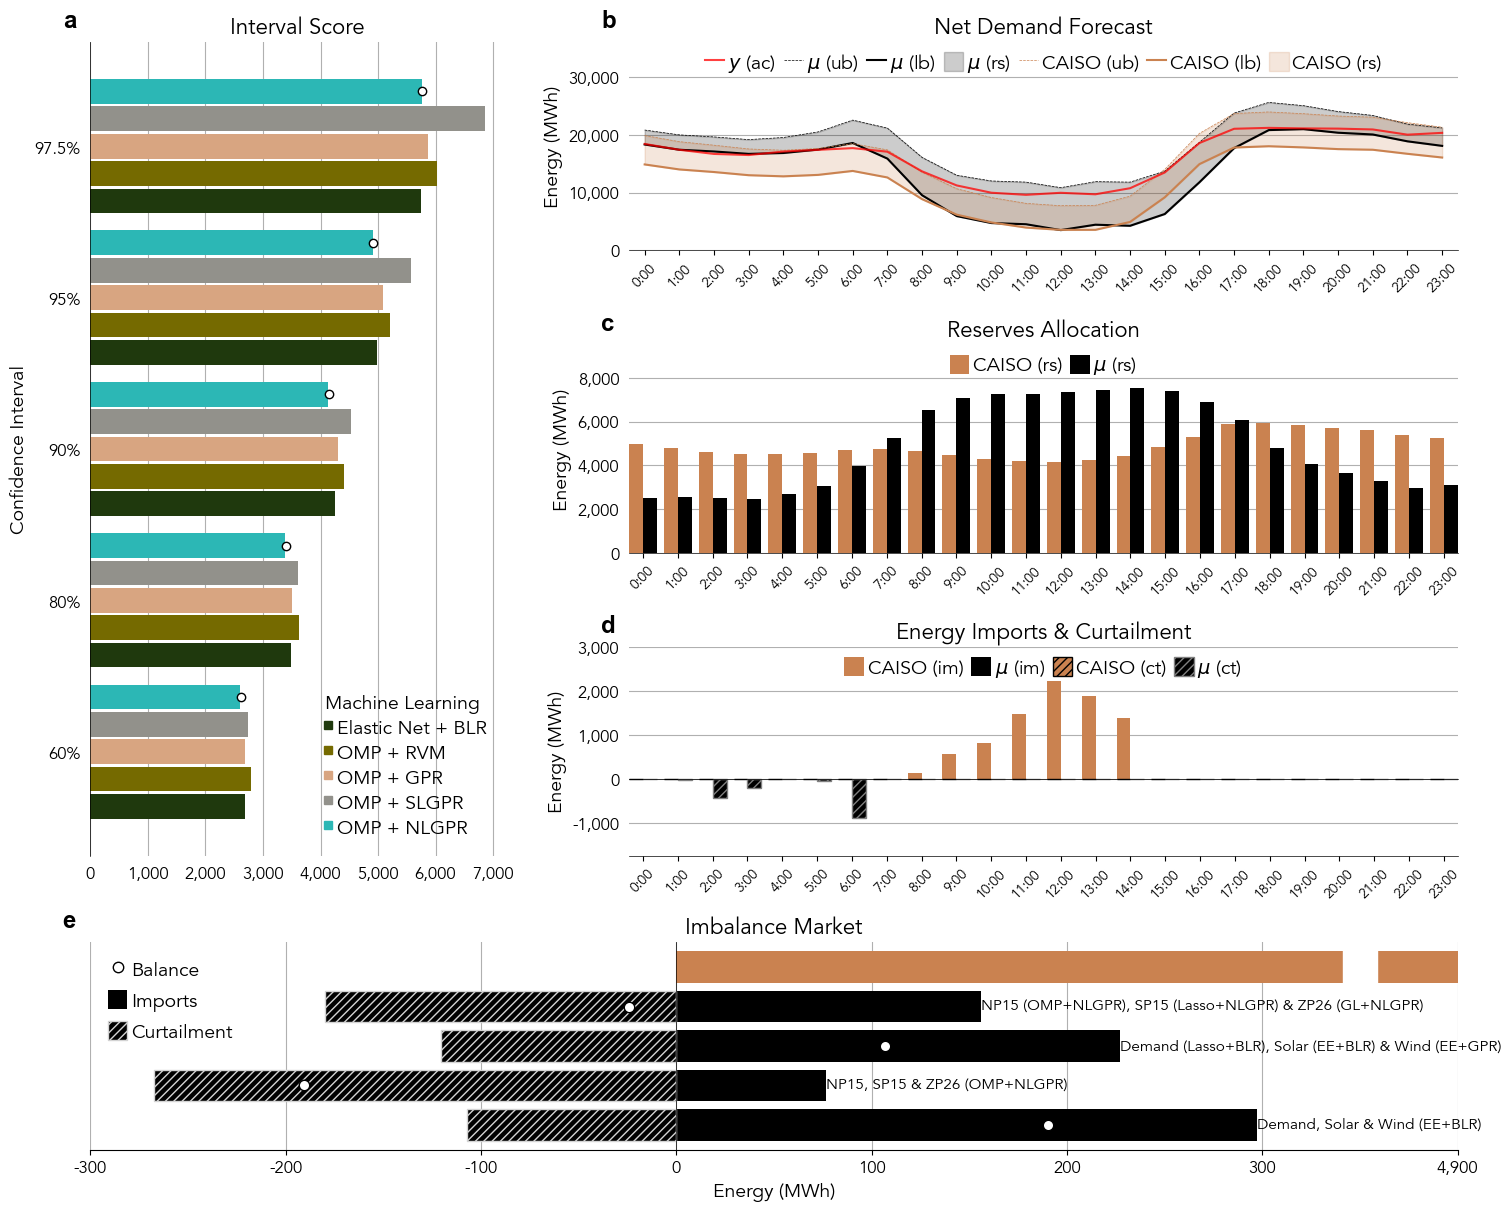

In [77]:
def _plot_ci_reserves(ax, y_, mu_caiso_, s2_caiso_, mu_ml_, s2_ml_, i_sel_sample, 
                      legend   = True, 
                      y_min    = -10., 
                      y_max    = 5000.,
                      title    = '',
                      color_2_ = colors_2_):
    
    x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)
    width = 0.45

    ax.set_title(title, size = 16)
    
    ax.plot(x_, y_, color     = 'r', 
                    linestyle = '-', 
                    label     = r'$y$ (ac)',
                    lw        = 1.5, 
                    alpha     = .75, 
                    zorder    = 12)
    
    ax.plot(x_, mu_ml_ + s2_ml_, color     = 'k', 
                                 linestyle = '--', 
                                 label     = '$\mu$ (ub)', 
                                 lw        = .5, 
                                 alpha     = 1., 
                                 zorder    = 10)

    ax.plot(x_, mu_ml_ - s2_ml_, color     = 'k', 
                                 linestyle = '-', 
                                 label     = '$\mu$ (lb)', 
                                 lw        = 1.5, 
                                 alpha     = 1., 
                                 zorder    = 10)

    ax.fill_between(x_, mu_ml_ + s2_ml_, mu_ml_ - s2_ml_, color  = 'k', 
                                                          label  = '$\mu$ (rs)', 
                                                          alpha  = .2, 
                                                          zorder = 7)
    
    ax.plot(x_, mu_caiso_ + s2_caiso_, color     = color_2_[2], 
                                       linestyle = '--', 
                                       label     = 'CAISO (ub)', 
                                       lw        = .5, 
                                       alpha     = 1., 
                                       zorder    = 11)

    ax.plot(x_, mu_caiso_ - s2_caiso_, color     = color_2_[2], 
                                       label     = 'CAISO (lb)', 
                                       linestyle = '-', 
                                       lw        = 1.5, 
                                       alpha     = 1., 
                                       zorder    = 11)

    ax.fill_between(x_, mu_caiso_ + s2_caiso_, mu_caiso_ - s2_caiso_, color  = color_2_[2], 
                                                                      label  = 'CAISO (rs)', 
                                                                      alpha  = .2, 
                                                                      zorder = 7)
    
    if legend:
        ax.legend(loc            = 'center', 
                  bbox_to_anchor = (.5, 0.9),
                  frameon        = False, 
                  columnspacing = 0.4, 
                  handletextpad = .2,
                  ncol           = 11,
                  prop           = {'size': 14})

    #ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
    ax.set_ylabel(r'Energy (MWh)', fontsize = 14)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_xlim(0 - width, 23 + width)

    ax.grid(axis = 'y')
    ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

    ax.yaxis.set_tick_params(labelsize = 12, left = False)

    ax.set_ylim(y_min, y_max)

    ax.axhline(y_min, linewidth = .5, 
                      linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)
    
def _plot_reserves(ax, y_, mu_caiso_, s2_caiso_, mu_ml_, s2_ml_, i_sel_sample, 
                   legend   = True, 
                   y_min    = -10., 
                   y_max    = 5000.,
                   title    = '',
                   color_2_ = colors_2_):
    
    x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)

    ax.set_title(title, size = 16)

    width = 0.4
    
    ax.bar(x_ - width/2., 2.*s2_caiso_, width  = width, 
                                        label  = 'CAISO (rs)', 
                                        color  = color_2_[2], 
                                        alpha  = 1., 
                                        zorder = 10)
    
    ax.bar(x_ + width/2., 2.*s2_ml_, width  = width, 
                                     label  = '$\mu$ (rs)', 
                                     color  = 'k', 
                                     alpha  = 1., 
                                     zorder = 10)
    
    if legend:
        ax.legend(loc            = 'center', 
                  bbox_to_anchor = (.5, 0.9),
                  frameon        = False, 
                  columnspacing  = 0.4, 
                  handletextpad  = .2,
                  ncol           = 11,
                  prop           = {'size': 14})

    ax.set_ylabel(r'Energy (MWh)', fontsize = 14)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_xlim(0 - width, 23 + width)

    ax.grid(axis = 'y')
    ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

    ax.yaxis.set_tick_params(labelsize = 12, left = False)

    ax.set_ylim(y_min, y_max)

    ax.axhline(y_min, linewidth = .5, 
                      linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)

def _plot_market(ax, caiso_im_, caiso_curtail_, ml_im_, ml_curtail_, i_sel_sample, 
                 legend    = True, 
                 y_min     = -1., 
                 y_max     = 5000.,
                 title     = '',
                 color_2_  = colors_2_):
    
    x_ = np.linspace(0, 23, 24, dtype = int)

    ax.set_title(title, size = 16)

    width = 0.4
    
    ax.bar(x_ - width/2., -caiso_im_, width  = width, 
                                      label  = 'CAISO (im)', 
                                      fc     = color_2_[2], 
                                      alpha  = 1., 
                                      zorder = 10)
    
    ax.bar(x_ + width/2., -ml_im_, width  = width, 
                                   label  = '$\mu$ (im)', 
                                   fc     = 'k', 
                                   alpha  = 1., 
                                   zorder = 10)
    
    ax.bar(x_ - width/2., -caiso_curtail_, width  = width, 
                                           label  = 'CAISO (ct)', 
                                           lw     = 1., 
                                           hatch  = '////', 
                                           fc     = color_2_[2], 
                                           ec     = 'k', 
                                           alpha  = 1., 
                                           zorder = 10)
    
    ax.bar(x_ + width/2., -ml_curtail_, width  = width, 
                                        label  = '$\mu$ (ct)', 
                                        lw     = 1., 
                                        hatch  = '////', 
                                        fc     = 'k', 
                                        ec     = 'gray', 
                                        alpha  = 1., 
                                        zorder = 10)
    
    if legend:
        ax.legend(loc            = 'center', 
                  bbox_to_anchor = (.5, 0.9),
                  frameon        = False, 
                  columnspacing  = 0.4, 
                  handletextpad  = .2,
                  ncol           = 11,
                  prop           = {'size': 14})

    #ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
    ax.set_ylabel(r'Energy (MWh)', fontsize = 14)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_xlim(0 - width, 23 + width)

    ax.grid(axis = 'y')
    ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

    ax.yaxis.set_tick_params(labelsize = 12, left = False)

    ax.set_ylim(y_min, y_max)

    ax.axhline(0., linewidth = .5, 
                   linestyle = '-', 
                   color     = 'k', 
                   clip_on   = False, 
                   zorder    = 10)

    ax.axhline(y_min, linewidth = .5, 
                      linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)

    
def _plot_is(ax, Scores_, zones_p_, colors_, 
             legend_title = '',
             title  = '',
             xlabel = 'Confidence Interval',
             ylabel = '', 
             labels = True,
             legend = False):
    
    interval_scores_ = ['IS60','IS80','IS90','IS95', 'IS975']
    dense_methods_   = ['BLR', 'RVM', 'GPR', 'MNGPR', 'MRGPR']

    x_ = np.linspace(0, .333*len(dense_methods_), len(dense_methods_))

    width  = 0.375
    offset = 2.3
    
    ax.set_title(title, size = 16)
    
    ticks_  = []
    values_ = []
    j       = 0
    legend_labels_ = []
    for interval_score in interval_scores_:
        i = 0
        for dense_method in dense_methods_:
            idx_1_ = (Scores_['dense_method'] == dense_method) & (Scores_['score'] == 'IS')

     
            #idx_1_ = (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            df_ = Scores_.loc[idx_1_ & (Scores_['IS'] == Scores_.loc[idx_1_, 'IS'].min())]
            
            p = ax.barh(x_[i], Scores_.loc[idx_1_, interval_score].min(), width, 
                        color  = colors_[i], 
                        zorder = 9, 
                        align  = 'center')
            
            if (j == 0):
                sparse_method = df_['sparse_method'].to_list()[0].replace('_', ' ').title()
                if sparse_method == 'Omp': sparse_method = 'OMP'
                if dense_method == 'MNGPR': dense_method = 'SLGPR'
                if dense_method == 'MRGPR': dense_method = 'NLGPR'

                legend_labels_.append(r'{} + {}'.format(sparse_method, dense_method))
                
            if df_['IS'].min() == Scores_.loc[(Scores_['score'] == 'IS'), 'IS'].min():
                ax.scatter(df_[interval_score].min(), x_[i], marker    = 'o', 
                                                             color     = 'w', 
                                                             edgecolor = 'k', 
                                                             lw        = 1., 
                                                             zorder    = 10)
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
    
    ax.set_yticks(ticks_[:len(interval_scores_)], ['60%', '80%', '90%', '95%', '97.5%'], fontsize = 12)
    
    #plt.xlim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles         = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 14,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   labelspacing   = 0.2,
                   #bbox_to_anchor = [1., .825],
                   frameon        = False)
    
    ax.grid(axis = 'x')

    ax.xaxis.set_tick_params(labelsize = 12, left = False)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)
    
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    ax.set_xlabel(ylabel, fontsize = 14)
    ax.set_ylabel(xlabel, fontsize = 14)
    
    ax.axvline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

def _plot_imblance(ax, df_, colors_2_,
                   title  = '',
                   x_min  = -300,
                   x_max  = 400,
                   legend = True):

    y_ = np.linspace(0, df_.shape[0] - 1, df_.shape[0], dtype = int)

    ax.set_title(title, fontsize = 16)

    width = 0.2

    p = ax.barh(y_, df_['imports'], fc = 'k', alpha = 1., zorder = 9, label = 'Imports')
    ax.bar_label(p, labels = df_['model'].to_list(), size = 11)

    p = ax.barh(y_, df_['curtailment'], fc = 'k', hatch = '////', ec = 'lightgray', alpha  = 1., zorder = 9, label = 'Curtailment')

    ax.plot(df_['net'], y_, marker = 'o', ms = 7.5, mfc = 'w', mec = 'k', lw = 2.5, ls = 'None', label = 'Balance', alpha  = 1., zorder = 10)

    p = ax.barh(y_[-1] + 1, 4903.297, fc = colors_2_[2], alpha = 1., zorder = 9)
    #ax.bar_label(p, labels = ['CAISO'], size = 12)

    ax.plot(350, df_.shape[0], marker = 's', ms = 25, mfc = 'w', mec = 'w', lw = 2.5, ls = 'None', alpha  = 1., zorder = 11)

    ax.set_xlabel(r'Energy (MWh)', fontsize = 14)

    x_     = np.linspace(x_min, x_max, 8, dtype = int)
    x_labels_     = x_.copy()
    x_labels_[-1] = 4900
    
    ax.set_xticks(x_, [f'{x:,}' for x in x_labels_.tolist()], rotation = 0)
    ax.set_yticks([], [])

    ax.spines[['right', 'top', 'left']].set_visible(False)

    ax.grid(axis = 'x')
    #y_ = np.linspace(0, df_.shape[0], df_.shape[0] + 1, dtype = int)

    #ax.set_yticks(y_, df_['model'].to_list() + ['CAISO'], rotation = 0)

    ax.xaxis.set_tick_params(labelsize = 12)
    ax.yaxis.set_tick_params(labelsize = 12)

    ax.set_xlim(x_min, x_max + .1)

    ax.axvline(0., linewidth = .5, 
                      linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)

    if legend:
        ax.legend(loc           = 'upper left', 
                  frameon       = False, 
                  ncol          = 1,
                  columnspacing = 0.4, 
                  handletextpad = .2,
                  prop          = {'size': 14})


fig, _ax = plt.subplot_mosaic([['a', 'b'], 
                               ['a', 'c'], 
                               ['a', 'd'], 
                               ['e', 'e']], layout      = 'constrained', 
                                            gridspec_kw = {'width_ratios': [1, 2]}, 
                                            figsize     = (15, 12))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")
    
_plot_is(_ax['a'], ts_scores_, zones_, 
         colors_      = colors_3_, 
         title        = 'Interval Score',
         legend_title = 'Machine Learning',
         labels       = False,
         legend       = True)

_plot_ci_reserves(_ax['b'], net_, net_caiso_, rs_caiso_, net_ml_, rs_ml_, i_sample, 
                  title  = 'Net Demand Forecast',
                  legend = True, 
                  y_min  = -1., 
                  y_max  = 36000.)

_plot_reserves(_ax['c'], net_, net_caiso_, rs_caiso_, net_ml_, rs_ml_, i_sample, 
               title  = 'Reserves Allocation',
               legend = True, 
               y_min  = -1., 
               y_max  = 9500.)

_plot_market(_ax['d'], caiso_im_, caiso_curtail, ml_im_, ml_curtail_, i_sample, 
             title  = 'Energy Imports & Curtailment', 
             legend = True, 
             y_min  = -1750., 
             y_max  = 3000.)

_plot_imblance(_ax['e'], df_, colors_2_,
               x_min    = -300,
               title    = r'Imbalance Market',
               x_max    = 400,
               legend   = True)
        
plt.savefig(path_to_images + f'reserves_allocation_{i_sample}.pdf', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [78]:
df_['total'] = np.absolute(df_['imports']) + np.absolute(df_['curtailment'])
print(df_)

                                               model     imports  curtailment  \
0                      Demand, Solar & Wind (EE+BLR)  297.410181  -107.043223   
1                      NP15, SP15 & ZP26 (OMP+NLGPR)   76.484912  -267.304793   
2  Demand (Lasso+BLR), Solar (EE+BLR) & Wind (EE+...  227.241111  -120.464089   
3  NP15 (OMP+NLGPR), SP15 (Lasso+NLGPR) & ZP26 (G...  155.920606  -179.927053   

          net       total  
0  190.366958  404.453404  
1 -190.819881  343.789705  
2  106.777022  347.705200  
3  -24.006447  335.847659  
